In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


## Import required libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
import torch

In [5]:
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')

In [6]:
data = df.head(2000)

In [7]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
df.shape

(568454, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [10]:
df['Text'].values[1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [11]:
df.columns.tolist()

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


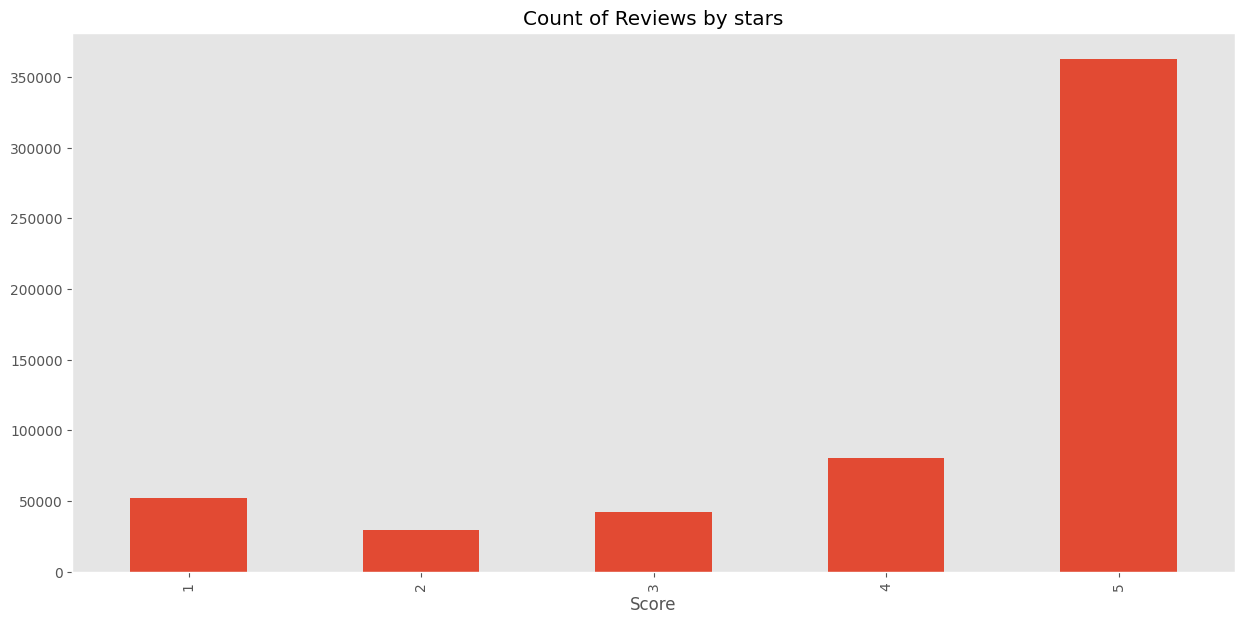

In [13]:
df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by stars',
                                            figsize = (15,7), )
plt.grid()
plt.show()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


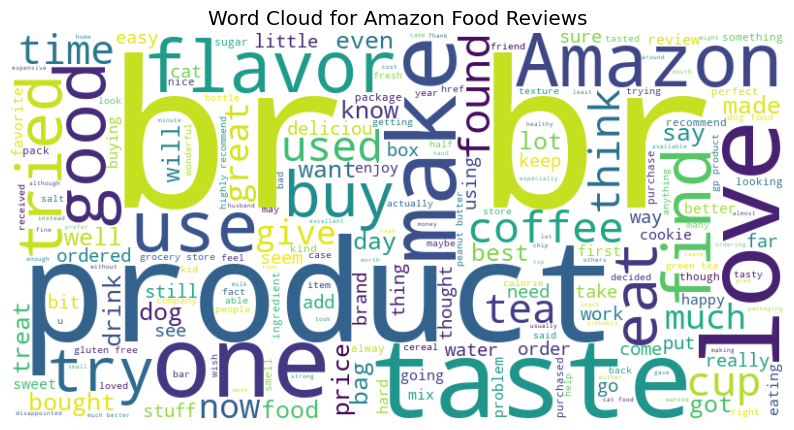

In [14]:
# Word cloud for most common words in the 'Text' column
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
text = " ".join(review for review in df['Text'] if not review in stop_words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Amazon Food Reviews')
plt.axis('off')
plt.show()

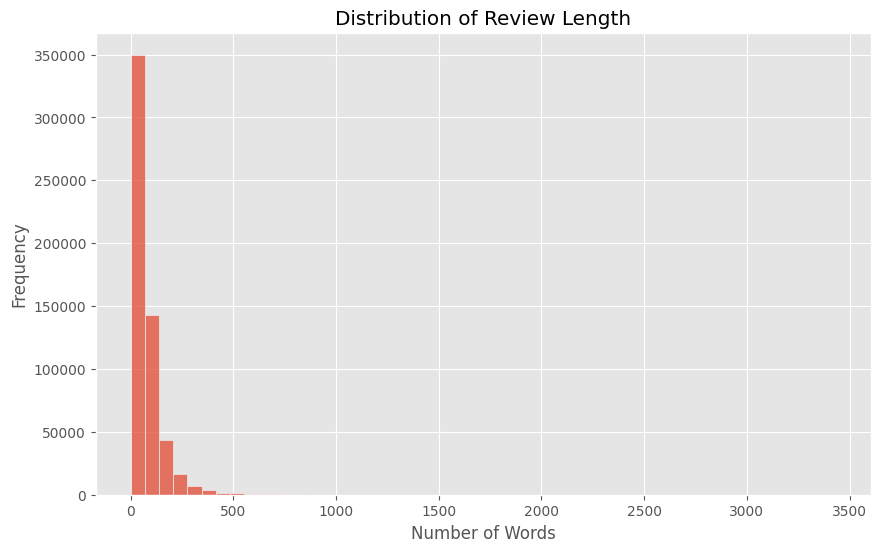

In [15]:
df['Text_Length'] = df['Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Text_Length', bins=50)
plt.title('Distribution of Review Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## VADER for Sentiment Analysis

In [16]:
sid = SentimentIntensityAnalyzer()

In [17]:
## perform sentiment analysis on the first sample
text = df['Text'].values[0]
print(text)
print('''----------------------------
Score Associated:''')
print(df['Score'].values[0])
print('''-----------------------------
Sentiment Scores using VEDAR sentiment Analyser''')
sentiment_scores = sid.polarity_scores(text)
sentiment_scores

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
----------------------------
Score Associated:
5
-----------------------------
Sentiment Scores using VEDAR sentiment Analyser


{'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'compound': 0.9441}

In [18]:
## Intrepret the results
compound_score = sentiment_scores['compound']

if compound_score >= 0.05:
    sentiment = 'Positive'
elif compound_score <= -0.05:
    sentiment = 'Negative'
else:
    sentiment = 'Neutral'


In [19]:
print('Compound_score:{}, Sentiment:{}'.format(compound_score, sentiment))

Compound_score:0.9441, Sentiment:Positive


In [20]:
# Perform sentiment analysis for the 'Text' column
def get_sentiment(text):
    sentiment_scores = sid.polarity_scores(text)
    compound_score = sentiment_scores['compound']

    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment

In [22]:
# Apply sentiment analysis to the 'Text' column
data['Sentiment_Vedar'] = data['Text'].apply(get_sentiment)

# Print the result
data.head(3)

/tmp/ipykernel_28/907550735.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_Vedar'] = data['Text'].apply(get_sentiment)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Vedar
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive


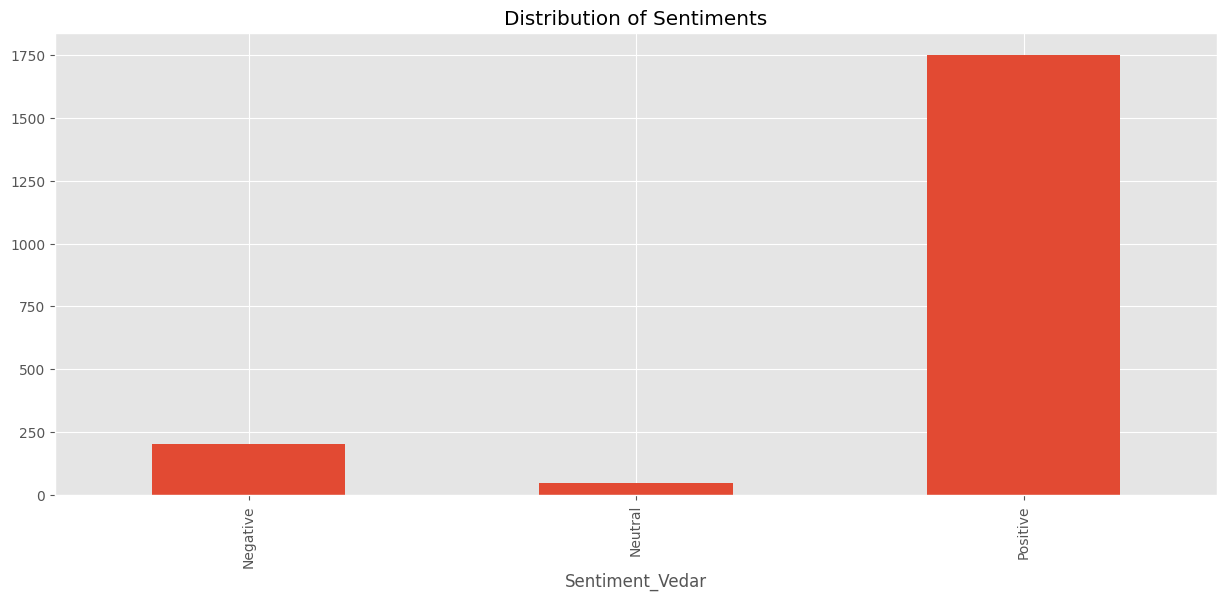

In [23]:
data['Sentiment_Vedar'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of Sentiments',
                                                figsize = (15,6))
plt.show()

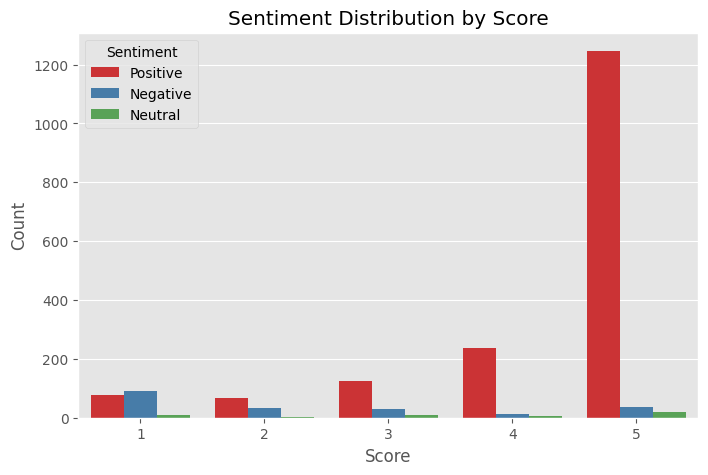

In [24]:
# Create a bar plot to visualize the relationship between the score and the sentiment
plt.figure(figsize=(8, 5))
sns.countplot(x='Score', hue='Sentiment_Vedar', data=data, palette='Set1')
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Sentiment Distribution by Score')
plt.legend(title='Sentiment')
plt.show()

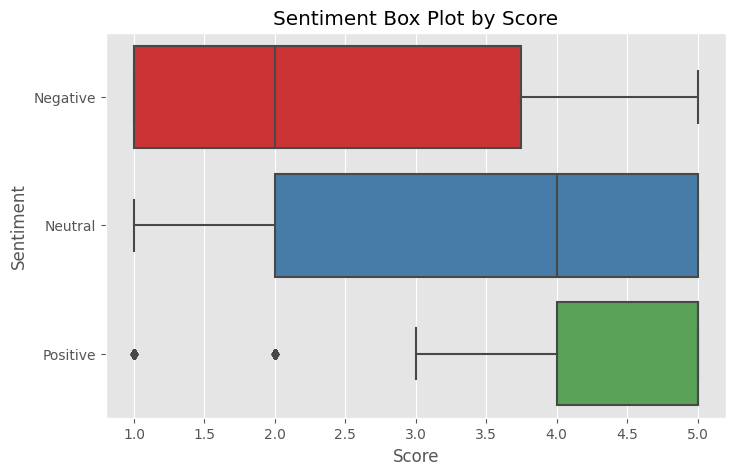

In [25]:
# Create a box plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Score', y='Sentiment_Vedar', data=data, order=['Negative', 'Neutral', 'Positive'], palette='Set1')
plt.xlabel('Score')
plt.ylabel('Sentiment')
plt.title('Sentiment Box Plot by Score')
plt.show()


## Roberta Pretrained Model

In [26]:
from transformers import pipeline
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_task = pipeline("sentiment-analysis")
print(text)
print('''------------------------------
Result of the model:''')
sentiment_task(text)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
------------------------------
Result of the model:


[{'label': 'POSITIVE', 'score': 0.9983851909637451}]

In [27]:
model = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [30]:
scores

array([0.01057769, 0.03881576, 0.9506067 ], dtype=float32)

In [31]:
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) positive 0.9506
2) neutral 0.0388
3) negative 0.0106


In [32]:
## Apply the model on the whole dataset
def predict_sentiment(text):
    try:
        
        inputs = tokenizer(text, return_tensors='pt')
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1)

        if predicted_class.item() == 2:
            predicted_class = 'Positive'
        elif predicted_class.item() == 1:
            predicted_class = 'Neutral'
        elif predicted_class.item() == 0:  # Assuming class 0 corresponds to 'Negative'
            predicted_class = 'Negative'
        return predicted_class
    except RuntimeError:
        print('Big size')
        



In [33]:

# Apply sentiment analysis to the DataFrame
data['Sentiment_Roberta'] = data['Text'].apply(predict_sentiment)

Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size
Big size


/tmp/ipykernel_28/763512876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_Roberta'] = data['Text'].apply(predict_sentiment)


In [34]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Vedar,Sentiment_Roberta
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Neutral,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,Positive


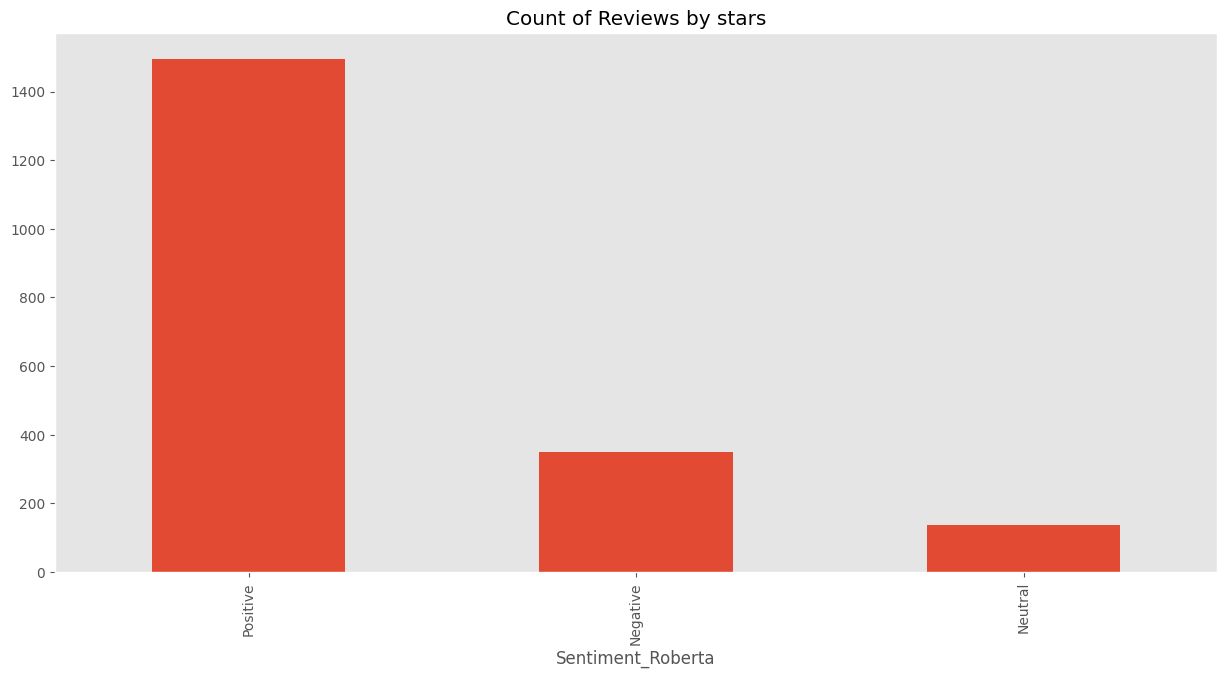

In [35]:
data['Sentiment_Roberta'].value_counts().plot(kind = 'bar', title = 'Count of Reviews by stars',
                                            figsize = (15,7) )
plt.grid()
plt.show()